# RNAseq data normalization and transformation

## Jen Wisecaver 
#### 2019-09-20

This tutorial walks you through preparing a gene-level expression matrix based on transcript-level abundance estimates output from Kallisto. 

## Step 1: Prepare input files
We will be using the [tximport](https://bioconductor.org/packages/release/bioc/html/tximport.html) bioconductor package for importing and summarizing the data from Kallisto. See this [tutorial](https://bioconductor.org/packages/release/bioc/vignettes/tximport/inst/doc/tximport.html#import-transcript-level-estimates) for additional ways to import data from different sources (e.g. Salmon or RSEM).

### Abundance files
Prepare a list of all the `abundance.h5` files that you want to include in your matrix. Include the full path to each file. Store the list in a textfile, one abundance file per line. 

In [1]:
filesfile <- 'abundance_files.txt'

cat(system((paste('head -n 5', filesfile)), intern=TRUE), sep='\n')

/tmp/3prime_RNAseq/HappyLeaf_Purdue_1/abundance.h5
/tmp/3prime_RNAseq/HappyLeaf_Purdue_2/abundance.h5
/tmp/3prime_RNAseq/HappyLeaf_Purdue_3/abundance.h5
/tmp/3prime_RNAseq/HappyLeaf_Purdue_4/abundance.h5
/tmp/3prime_RNAseq/HappyLeaf_Purdue_5/abundance.h5


Read in the list of files and store as a list. Then assign a sample ID to each file. I find it easiest to make each Kallisto output directory the same as the sample ID. That way I can use `str_split` to get the sample IDs directly from the file list.

In [22]:
library(stringr)
files <- scan(filesfile, what = 'list')
file_names <- str_split(files, '/', simplify = TRUE)
file_names <- file_names[,ncol(file_names)-1]
names(files) <- file_names
head(files)

HappyLeaf_Purdue_1 
"/tmp/3prime_RNAseq/HappyLeaf_Purdue_1/abundance.h5" 
                                  HappyLeaf_Purdue_2 
"/tmp/3prime_RNAseq/HappyLeaf_Purdue_2/abundance.h5" 
                                  HappyLeaf_Purdue_3 
"/tmp/3prime_RNAseq/HappyLeaf_Purdue_3/abundance.h5" 
                                  HappyLeaf_Purdue_4 
"/tmp/3prime_RNAseq/HappyLeaf_Purdue_4/abundance.h5" 
                                  HappyLeaf_Purdue_5 
"/tmp/3prime_RNAseq/HappyLeaf_Purdue_5/abundance.h5" 
                                  HappyLeaf_Purdue_6 
"/tmp/3prime_RNAseq/HappyLeaf_Purdue_6/abundance.h5"

### Transcript-to-gene lookup table
Prepare a transcript-to-gene lookup table to pass to tximport. The table must consist of two columns with the first column containing the transcript ID and second column containing the gene ID. The column names do not matter, but the transcript ID must be the same one used in the abundance files.

In [3]:
t2gfile <- '~/Desktop/transcripts2genes.txt'

cat(system((paste('head -n 5', t2gfile)), intern=TRUE), sep='\n')

TXNAME	GENEID
Sevir.1G000100.1.v2.1	Sevir.1G000100
Sevir.1G000200.1.v2.1	Sevir.1G000200
Sevir.1G000200.2.v2.1	Sevir.1G000200
Sevir.1G000300.1.v2.1	Sevir.1G000300


In [4]:
tx2gene <- read.table(t2gfile, sep="\t", header=TRUE)
head(tx2gene)

TXNAME,GENEID
<fct>,<fct>
Sevir.1G000100.1.v2.1,Sevir.1G000100
Sevir.1G000200.1.v2.1,Sevir.1G000200
Sevir.1G000200.2.v2.1,Sevir.1G000200
Sevir.1G000300.1.v2.1,Sevir.1G000300
Sevir.1G000400.1.v2.1,Sevir.1G000400
Sevir.1G000501.1.v2.1,Sevir.1G000501


### Sample table
Prepare a sample table describing the experiment design. This table should include the sample ID in the first column and the experimental condition in the second. Label the second column 'condition'.

In [5]:
samplefile <- 'sample_conditions.txt'

cat(system((paste('head -n 5', samplefile)), intern=TRUE), sep='\n')

run	condition	tissue
HappyLeaf_Purdue_1	HappyLeaf_Purdue_L	Leaf
HappyLeaf_Purdue_2	HappyLeaf_Purdue_L	Leaf
HappyLeaf_Purdue_3	HappyLeaf_Purdue_L	Leaf
HappyLeaf_Purdue_4	HappyLeaf_Purdue_L	Leaf


In [6]:
sampleTable <- read.table(samplefile, sep="\t", header=TRUE)
head(sampleTable)

run,condition,tissue
<fct>,<fct>,<fct>
HappyLeaf_Purdue_1,HappyLeaf_Purdue_L,Leaf
HappyLeaf_Purdue_2,HappyLeaf_Purdue_L,Leaf
HappyLeaf_Purdue_3,HappyLeaf_Purdue_L,Leaf
HappyLeaf_Purdue_4,HappyLeaf_Purdue_L,Leaf
HappyLeaf_Purdue_5,HappyLeaf_Purdue_L,Leaf
HappyLeaf_Purdue_6,HappyLeaf_Purdue_L,Leaf


## Step 2: Import and transform data
Import the abundance estimates using `tximport`. We are working with 3'tagged RNAseq in this example. Therefore set `countsFromAbundance = "no"` because these counts do not have a length bias.

In [23]:
library(tximport)
#library(rhdf5)
txi <- tximport(files, type = "kallisto", tx2gene = tx2gene, countsFromAbundance = "no")
names(txi)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 
summarizing abundance
summarizing c

[1] "abundance"           "counts"              "length"             
[4] "countsFromAbundance"

`tximport` returns a list of matrices: "abundance", "counts", "length", "countsFromAbundance". 

In [8]:
# raw counts (not scaled by abundances)
head(txi$counts)

,HappyLeaf_Purdue_1,HappyLeaf_Purdue_2,HappyLeaf_Purdue_3,HappyLeaf_Purdue_4,HappyLeaf_Purdue_5,HappyLeaf_Purdue_6,HappyLeaf_Purdue_7,HappyLeaf_Purdue_8,HappyLeaf_APL_1,HappyLeaf_APL_2,⋯,Cold_17C_NAC_1_L,Cold_17C_NAC_2_L,Cold_17C_NAC_3_L,Salt_100mM_NAC_1_S,Salt_100mM_NAC_2_S,Salt_100mM_NAC_3_S,Salt_100mM_NAC_4_S,Salt_100mM_NAC_5_S,Cold_17C_NAC_4_L,Cold_17C_NAC_5_L
Sevir.1G000100,573,805.6613,562,426.000000,433,658.00000,371.00000,369.00000,2395.666538,2708.672098,⋯,549,1802.734704,1591,276.000000,405.00000,15,1757.34992,97.000000,2618.471139,483
Sevir.1G000200,132,225.0000,292,140.857466,132,171.82549,125.82549,105.82549,402.918362,484.922063,⋯,56,79.912745,86,304.912745,436.82549,0,647.65098,112.912745,129.912745,38
Sevir.1G000300,0,0.0000,0,4.142534,0,4.17451,4.17451,4.17451,2.081638,2.077937,⋯,0,2.087255,0,2.087255,4.17451,0,8.34902,2.087255,2.087255,0
Sevir.1G000400,27,82.0000,81,63.000000,48,47.00000,85.00000,34.00000,73.000000,47.000000,⋯,29,18.000000,13,16.000000,94.00000,5,115.00000,65.000000,35.000000,1
Sevir.1G000501,11,21.0000,12,5.000000,10,8.00000,11.00000,7.00000,9.000000,13.000000,⋯,4,20.000000,19,13.000000,53.00000,0,71.00000,2.000000,16.000000,5
Sevir.1G000600,20,36.0000,27,20.000000,16,11.00000,15.00000,7.00000,39.000000,73.000000,⋯,6,18.000000,19,6.000000,18.00000,0,96.00000,6.000000,26.000000,11


**If you are working with full-length RNAseq**, you should set `countsFromAbundance = "scaledTPM"`. Notice how the counts matrix changes.

In [9]:
scaledtxi <- tximport(files, type = "kallisto", tx2gene = tx2gene, countsFromAbundance = "scaledTPM")
head(scaledtxi$counts)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 
summarizing abundance
summarizing c

,HappyLeaf_Purdue_1,HappyLeaf_Purdue_2,HappyLeaf_Purdue_3,HappyLeaf_Purdue_4,HappyLeaf_Purdue_5,HappyLeaf_Purdue_6,HappyLeaf_Purdue_7,HappyLeaf_Purdue_8,HappyLeaf_APL_1,HappyLeaf_APL_2,⋯,Cold_17C_NAC_1_L,Cold_17C_NAC_2_L,Cold_17C_NAC_3_L,Salt_100mM_NAC_1_S,Salt_100mM_NAC_2_S,Salt_100mM_NAC_3_S,Salt_100mM_NAC_4_S,Salt_100mM_NAC_5_S,Cold_17C_NAC_4_L,Cold_17C_NAC_5_L
Sevir.1G000100,394.530108,632.406926,472.256445,354.1597673,289.188734,402.247372,240.6590283,294.869478,1203.0431160,1886.357840,⋯,459.094999,1399.2071001,1199.091508,280.0818594,374.7238501,6.844755,1244.063515,96.9952591,1764.653789,365.6063765
Sevir.1G000200,39.419671,76.602014,106.423604,50.7905628,38.016935,45.558398,35.4005827,36.678137,87.7577370,146.471498,⋯,20.311022,26.9017022,28.112154,134.2038599,175.2983448,0.000000,198.856076,48.9705825,37.973184,12.4756665
Sevir.1G000300,0.000000,0.000000,0.000000,0.7780816,0.000000,0.576557,0.6117911,0.753665,0.2361725,0.326941,⋯,0.000000,0.3660118,0.000000,0.4785428,0.8726322,0.000000,1.335332,0.4715456,0.317802,0.0000000
Sevir.1G000400,17.146681,59.367500,62.779429,48.3082091,29.568240,26.500614,50.8555012,25.059542,33.8118123,30.189524,⋯,22.367579,12.8858612,9.036833,14.9756832,80.2185725,2.104396,75.088411,59.9491312,21.755573,0.6981639
Sevir.1G000501,16.672927,36.287502,22.198134,9.1506778,14.702362,10.765915,15.7077713,12.313886,9.9492643,19.929878,⋯,7.363492,34.1722686,31.523134,29.0410882,107.9507880,0.000000,110.646146,4.4025308,23.736973,8.3316357
Sevir.1G000600,3.325985,6.825138,5.479868,4.0159138,2.580942,1.624145,2.3500888,1.351034,4.7302511,12.278782,⋯,1.211843,3.3743292,3.458601,1.4705910,4.0224771,0.000000,16.414222,1.4490881,4.232041,2.0110556


### Create Expression Matrices 

Create a DESeq dataset using `DESeqDataSetFromTximport`

In [24]:
library("DESeq2")
dds <- DESeqDataSetFromTximport(txi, sampleTable, ~condition)
dds <- estimateSizeFactors(dds)

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]
using counts and average transcript lengths from tximport
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not an warning or error]
using 'avgTxLength' from assays(dds), correcting for library size


`DESeqDataSetFromTximport` will automatically round txi$counts to the nearest integer

In [11]:
head(counts(dds))

,HappyLeaf_Purdue_1,HappyLeaf_Purdue_2,HappyLeaf_Purdue_3,HappyLeaf_Purdue_4,HappyLeaf_Purdue_5,HappyLeaf_Purdue_6,HappyLeaf_Purdue_7,HappyLeaf_Purdue_8,HappyLeaf_APL_1,HappyLeaf_APL_2,⋯,Cold_17C_NAC_1_L,Cold_17C_NAC_2_L,Cold_17C_NAC_3_L,Salt_100mM_NAC_1_S,Salt_100mM_NAC_2_S,Salt_100mM_NAC_3_S,Salt_100mM_NAC_4_S,Salt_100mM_NAC_5_S,Cold_17C_NAC_4_L,Cold_17C_NAC_5_L
Sevir.1G000100,573,806,562,426,433,658,371,369,2396,2709,⋯,549,1803,1591,276,405,15,1757,97,2618,483
Sevir.1G000200,132,225,292,141,132,172,126,106,403,485,⋯,56,80,86,305,437,0,648,113,130,38
Sevir.1G000300,0,0,0,4,0,4,4,4,2,2,⋯,0,2,0,2,4,0,8,2,2,0
Sevir.1G000400,27,82,81,63,48,47,85,34,73,47,⋯,29,18,13,16,94,5,115,65,35,1
Sevir.1G000501,11,21,12,5,10,8,11,7,9,13,⋯,4,20,19,13,53,0,71,2,16,5
Sevir.1G000600,20,36,27,20,16,11,15,7,39,73,⋯,6,18,19,6,18,0,96,6,26,11


### Remove genes with no expression
Perform only the bare minimum of filtering here to remove genes that have no expression at all. Additional filtering can be done later in the pipeline during the mutual rank calculation. 

In [12]:
nrow(dds)

[1] 38334

In [13]:
dds_filt <- dds[ rowSums(counts(dds)) > 0, ]
nrow(dds_filt)

[1] 35659

### Normalization
Normalize the counts data based on library size

In [33]:
normalized_matrix <- counts(dds_filt, normalized = TRUE)
head(normalized_matrix)

,HappyLeaf_Purdue_1,HappyLeaf_Purdue_2,HappyLeaf_Purdue_3,HappyLeaf_Purdue_4,HappyLeaf_Purdue_5,HappyLeaf_Purdue_6,HappyLeaf_Purdue_7,HappyLeaf_Purdue_8,HappyLeaf_APL_1,HappyLeaf_APL_2,⋯,Cold_17C_NAC_1_L,Cold_17C_NAC_2_L,Cold_17C_NAC_3_L,Salt_100mM_NAC_1_S,Salt_100mM_NAC_2_S,Salt_100mM_NAC_3_S,Salt_100mM_NAC_4_S,Salt_100mM_NAC_5_S,Cold_17C_NAC_4_L,Cold_17C_NAC_5_L
Sevir.1G000100,818.60757,688.03145,593.93174,546.774309,683.72923,766.887175,520.75968,640.549118,1366.738981,1455.742198,⋯,838.150282,1500.342914,1406.13913,258.229533,268.046506,1097.7215,539.767319,160.568519,1385.303928,1533.771929
Sevir.1G000200,189.19082,192.69070,309.59081,181.561016,207.90806,201.112479,177.43487,184.602223,230.626285,261.470198,⋯,85.771414,66.786669,76.25381,286.287019,290.162681,0.0000,199.716902,187.660168,69.011865,121.060438
Sevir.1G000300,0.00000,0.00000,0.00000,5.134031,0.00000,4.661928,5.61466,6.943622,1.140851,1.074745,⋯,0.000000,1.664274,0.00000,1.871228,2.647373,0.0000,2.457677,3.310691,1.058292,0.000000
Sevir.1G000400,38.57313,69.99824,85.60226,80.860989,75.79446,54.777655,119.31152,59.020786,41.641046,25.256509,⋯,44.273876,14.978465,11.48951,14.969828,62.213263,365.9072,35.329107,107.597461,18.520106,3.175511
Sevir.1G000501,15.71498,17.92638,12.68182,6.417539,15.79051,9.323856,15.44031,12.151338,5.133828,6.985843,⋯,6.106742,16.642739,16.79236,12.162985,35.077691,0.0000,21.811884,3.310691,8.466334,15.877556
Sevir.1G000600,28.57269,30.73093,28.53409,25.670155,25.26482,12.820302,21.05497,12.151338,22.246586,39.228195,⋯,9.160112,14.978465,16.79236,5.613685,11.913178,0.0000,29.492124,9.932073,13.757793,34.930624


### Variance stabilization
Use `vst` to create a variance stabilized matrix that controls for the fact that gene variance is not consistent across the dataset. See this helpful [tutorial](http://master.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#pre-filtering-the-dataset) for more information, including alternative methods for variance stabilization (e.g. rlog). FYI, the vst function also normalizes the matrix prior variance stabilization. 

In [34]:
#vsd <- vst(dds_filt, blind = FALSE)
normalized_vst_matrix <- assay(vsd)
head(normalized_vst_matrix)

,HappyLeaf_Purdue_1,HappyLeaf_Purdue_2,HappyLeaf_Purdue_3,HappyLeaf_Purdue_4,HappyLeaf_Purdue_5,HappyLeaf_Purdue_6,HappyLeaf_Purdue_7,HappyLeaf_Purdue_8,HappyLeaf_APL_1,HappyLeaf_APL_2,⋯,Cold_17C_NAC_1_L,Cold_17C_NAC_2_L,Cold_17C_NAC_3_L,Salt_100mM_NAC_1_S,Salt_100mM_NAC_2_S,Salt_100mM_NAC_3_S,Salt_100mM_NAC_4_S,Salt_100mM_NAC_5_S,Cold_17C_NAC_4_L,Cold_17C_NAC_5_L
Sevir.1G000100,9.712636,9.468550,9.262896,9.147636,9.459761,9.620833,9.079874,9.368443,10.438006,10.527724,⋯,9.745857,10.570667,10.478412,8.121176,8.171232,10.126974,9.129695,7.496365,10.457186,10.602036
Sevir.1G000200,7.709198,7.733184,8.365673,7.655478,7.833051,7.789309,7.625566,7.677132,7.970312,8.137893,⋯,6.719019,6.428596,6.580890,8.259853,8.278000,3.363299,7.780159,7.698581,6.465903,7.138432
Sevir.1G000300,3.363299,3.363299,3.363299,4.362231,3.363299,4.316871,4.406088,4.517344,3.841462,3.827524,⋯,3.363299,3.939636,3.363299,3.973924,4.087412,3.363299,4.061500,4.170999,3.823987,3.363299
Sevir.1G000400,5.840639,6.482129,6.716678,6.649441,6.573869,6.208029,7.120312,6.290004,5.918186,5.439559,⋯,5.981384,5.012546,4.824443,5.012116,6.348650,8.593260,5.753494,6.992629,5.176896,4.154747
Sevir.1G000501,5.048630,5.150857,4.892275,4.474882,5.052270,4.689361,5.035302,4.862601,4.362212,4.520671,⋯,4.448862,5.092580,5.099519,4.863261,5.746499,3.363299,5.312085,4.170999,4.630713,5.056450
Sevir.1G000600,5.551402,5.619367,5.550153,5.454048,5.439852,4.899895,5.282271,4.862601,5.328894,5.857573,⋯,4.678415,5.012546,5.099519,4.406001,4.849020,3.363299,5.580786,4.729046,4.950183,5.742390


You can vizualize the effect of the transformation two ways. The first method was taken from this [tutorial](http://master.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html#pre-filtering-the-dataset).

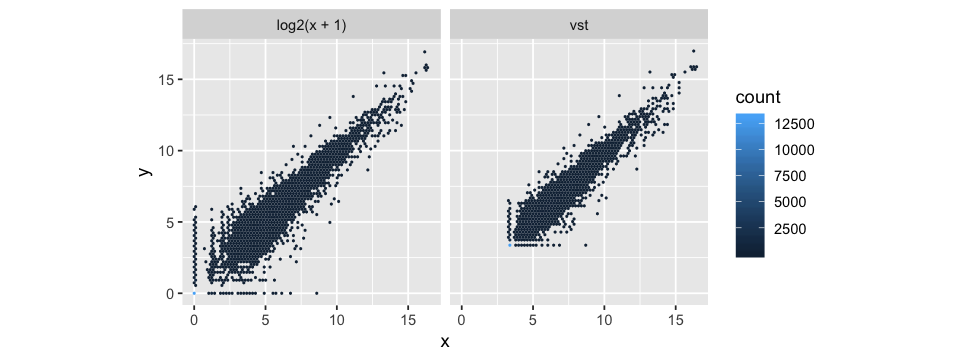

In [25]:
library("dplyr")
library("ggplot2")
options(repr.plot.width=8, repr.plot.height=3)

df <- bind_rows(as_data_frame(log2(counts(dds_filt, normalized=TRUE)[, 1:2]+1)) %>% mutate(transformation = "log2(x + 1)"), as_tibble(assay(vsd)[, 1:2]) %>% mutate(transformation = "vst"))
colnames(df)[1:2] <- c("x", "y")  
ggplot(df, aes(x = x, y = y)) + geom_hex(bins = 80) + coord_fixed() + facet_grid( . ~ transformation)

The second method was taken from this [tutorial](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#variance-stabilizing-transformation)

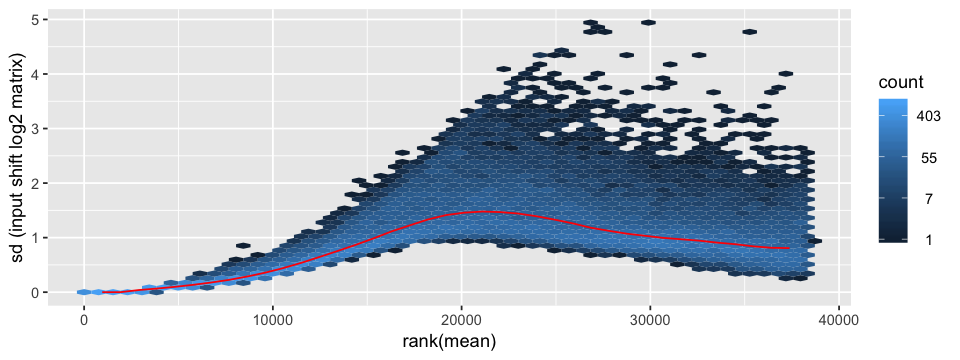

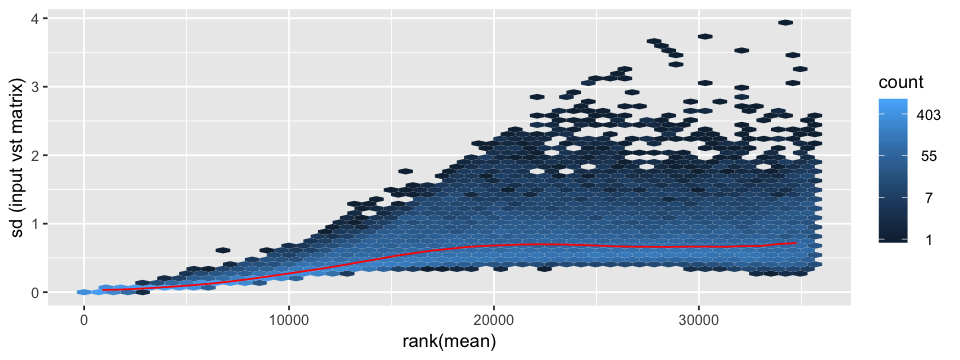

In [26]:
# this gives log2(n + 1)
ntd <- normTransform(dds)
library("vsn")
meanSdPlot(assay(ntd),ylab  = "sd (input shift log2 matrix)")
meanSdPlot(assay(vsd),ylab  = "sd (input vst matrix)")

Notice that in both plots the shifted log2 data has elevated standard deviation in the lower count range, whereas for the variance stabilized data the standard deviation is more constant along the whole dynamic range.

## Step 3: Create stats table for downstream filtering

Prior to constructing Mutual Ranks, it is often best to filter out very lowly expressed genes and/or genes that have very low variance across the analysis. I've found that the importance of filtering is inversely correlated with the number of columns (samples) in the matrix. Smaller matrices have less power and are more likely to have genes appear correlated due to artifact. In these small matricies, I often enforce stricter thresholds for minimum expression/variance.  

Here, we tabulate expression statistics for each gene in the analysis. We can use the output to select genes to exclude later, during the Mutual Rank calculation step in the pipeline.

In [20]:
# Tally number of genes with expression greater than zero
df_binary <- normalized_matrix
df_binary[df_binary == 0] <- 0
df_binary[df_binary > 0] <- 1
stats_df <- as.data.frame(rowSums(df_binary))
names(stats_df) <- c('no. samples with count > 0')

# Tally number of genes with expression greater than or equal to five
df_binary <- normalized_matrix
df_binary[df_binary < 5] <- 0
df_binary[df_binary > 0] <- 1
stats_df$'no. samples with count >= 5' = rowSums(df_binary)

# Tally number of genes with expression greater than or equal to ten
df_binary <- normalized_matrix
df_binary[df_binary < 10] <- 0
df_binary[df_binary > 0] <- 1
stats_df$'no. samples with count >= 10' = rowSums(df_binary)

# Calculate median expression genes in the normalized matrix
median_expression  <- apply(normalized_matrix, 1, median)
stats_df$'pre-VST median expression' = median_expression

# Calculate mean expression genes in the normalized matrix
mean_expression  <- apply(normalized_matrix, 1, mean)
stats_df$'pre-VST mean expression' = mean_expression

# Calculate expression variance genes in the normalized matrix
exp_variance <- apply(normalized_matrix, 1, var)
stats_df$'pre-VST expression variance' = exp_variance

# Calculate median expression genes in the VST matrix
median_expression  <- apply(normalized_vst_matrix, 1, median)
stats_df$'post-VST median expression' = median_expression

# Calculate mean expression genes in the VST matrix
mean_expression  <- apply(normalized_vst_matrix, 1, mean)
stats_df$'post-VST mean expression' = mean_expression

# Calculate expression variance genes in the VST matrix
exp_variance <- apply(normalized_vst_matrix, 1, var)
stats_df$'post-VST expression variance' = exp_variance

head(stats_df)

,no. samples with count > 0,no. samples with count >= 5,no. samples with count >= 10,pre-VST median expression,pre-VST mean expression,pre-VST expression variance,post-VST median expression,post-VST mean expression,post-VST expression variance
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Sevir.1G000100,268,268,268,846.703707,821.076136,143993.8782,9.760160,9.492740,0.8586298
Sevir.1G000200,266,266,266,199.626470,206.825829,5569.3377,7.779564,7.740717,0.3174881
Sevir.1G000300,198,100,40,3.280321,5.253322,102.5950,4.167370,4.131374,0.3542596
Sevir.1G000400,265,261,259,43.968279,55.213827,2195.4076,5.974197,5.986551,0.6212875
Sevir.1G000501,248,173,114,8.832155,10.368583,105.0703,4.656140,4.576665,0.3712323
Sevir.1G000600,259,245,215,25.691074,35.232838,4995.8952,5.454776,5.403842,0.7276728


## Step 4: Write Matrices to File
That's it! Write both matrices and the stats data frame to outfiles. These outfiles will serve as input for calculating Pearson's correlation coefficients

In [32]:
norm_outfil = 'gene_counts_normalized.matrix'
write.table(normalized_matrix, norm_outfil, sep="\t", quote = FALSE)

normVst_outfil = 'gene_counts_normalized_vst_transformed.matrix'
write.table(normalized_vst_matrix, normVst_outfil, sep="\t", quote = FALSE)

stats_outfil = 'gene_counts_statistics.txt'
write.table(stats_df, stats_outfil, sep="\t", quote = FALSE)